This section runs through the API for common tasks in machine learning. Refer to the links in each section to dive deeper.

本节将介绍机器学习中常见任务的API。请参阅每个部分中的链接以深入了解。

# 使用历史数据训练模型

### 本文档参考官方 Quick Start 改编而来 
参考：https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.

PyTorch有两个处理数据的原语:torch.utils.data.DataLoader 和 torch.utils.data.Dataset。Dataset存储样本及其相应的标签，DataLoader在Dataset周围包装一个可迭代对象。

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

PyTorch offers domain-specific libraries such as TorchText, TorchVision, and TorchAudio, all of which include datasets. For this tutorial, we will be using a TorchVision dataset.

PyTorch提供了特定领域的库，如TorchText, TorchVision和TorchAudio，它们都包含数据集。在本教程中，我们将使用TorchVision数据集。

The torchvision.datasets module contains Dataset objects for many real-world vision data like CIFAR, COCO (full list here). In this tutorial, we use the FashionMNIST dataset. Every TorchVision Dataset includes two arguments: transform and target_transform to modify the samples and labels respectively.

torchvision.datassets模块包含许多真实世界视觉数据的 Dataset 对象，如 CIFAR, COCO (完整列表在这里)。在本教程中，我们使用 MNIST 数据集。每个TorchVision数据集包含两个参数:transform和target_transform，分别用于修改样本和标签。

In [2]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

print("size of training_data", training_data.data.size())
print("size of test_data", test_data.data.size())


size of training_data torch.Size([60000, 28, 28])
size of test_data torch.Size([10000, 28, 28])


We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

我们将Dataset作为参数传递给DataLoader。这在我们的数据集上包装了一个可迭代对象，并支持自动批处理、采样、混排和多进程数据加载。这里我们定义了一个批处理大小为64，即dataloader可迭代对象中的每个元素将返回一批64个特征和标签。

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


预览数据的内容

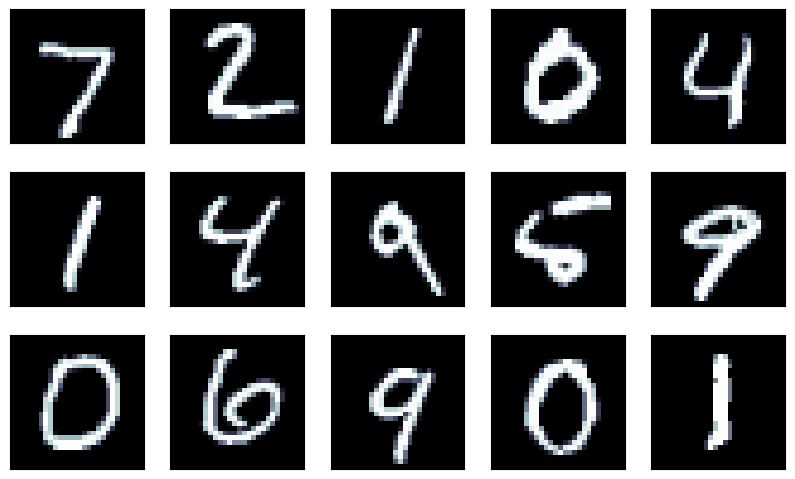

In [4]:
# 显示验证数据的样本图片
fig, ax = plt.subplots(3, 5, figsize=(10, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(X[i].reshape(28, 28), cmap="bone")
    axi.set(xticks=[], yticks=[])
plt.show()

In [5]:
# 打印训练数据中的标签值
print(y[0:3*5])

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1])


# 创建模型 Create the Models
To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the __init__ function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU or MPS if available.

为了在PyTorch中定义一个神经网络，我们创建了一个继承了nn.Module的类。我们在init函数中定义网络层，并在 forward 函数中指定数据如何通过网络函数。为了加速神经网络的操作，我们将其转移到GPU或MPS(如果可用)。

In [6]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


# 优化模型参数 Optimizing the Model Parameters
To train a model, we need a loss function and an optimizer.

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

在单个训练循环中，模型对训练数据集进行预测(批量提供给它)，并反向传播预测误差以调整模型的参数。

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model’s performance against the test dataset to ensure it is learning.

我们还根据测试数据集检查模型的性能，以确保它在学习。

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model’s accuracy and loss at each epoch; we’d like to see the accuracy increase and the loss decrease with every epoch.

训练过程在几个迭代( epochs )中进行。在每个时期，模型学习参数以做出更好的预测。我们打印出模型在每个时期的精度和损失;我们希望看到精度随着时间的推移而提高，损失随着时间的推移而减少。

In [20]:
epochs = 16
for t in range(epochs):
    print(f"Epoch {t+1} ... ")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    print("-------------------------------------------")
print("Done!")

Epoch 1 ... 
Accuracy: 94.8%, Avg loss: 0.174271
-------------------------------------------
Epoch 2 ... 
Accuracy: 94.8%, Avg loss: 0.173666
-------------------------------------------
Epoch 3 ... 
Accuracy: 94.8%, Avg loss: 0.173064
-------------------------------------------
Epoch 4 ... 
Accuracy: 94.8%, Avg loss: 0.172471
-------------------------------------------
Epoch 5 ... 
Accuracy: 94.8%, Avg loss: 0.171880
-------------------------------------------
Epoch 6 ... 
Accuracy: 94.9%, Avg loss: 0.171294
-------------------------------------------
Epoch 7 ... 
Accuracy: 94.9%, Avg loss: 0.170717
-------------------------------------------
Epoch 8 ... 
Accuracy: 94.9%, Avg loss: 0.170146
-------------------------------------------
Epoch 9 ... 
Accuracy: 95.0%, Avg loss: 0.169579
-------------------------------------------
Epoch 10 ... 
Accuracy: 95.0%, Avg loss: 0.169017
-------------------------------------------
Epoch 11 ... 
Accuracy: 95.0%, Avg loss: 0.168461
-------------------

# 保存 Saving Models
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).

保存模型的一种常用方法是序列化内部状态字典(包含模型参数)。

In [21]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


# 读取载入模型 Loading Models
The process for loading a model includes re-creating the model structure and loading the state dictionary into it.

加载模型的过程包括重新创建模型结构并将状态字典加载到模型中。

In [22]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

This model can now be used to make predictions.
现在，这个模型现在可以被用来做预测数据。

In [23]:
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "7", Actual: "7"


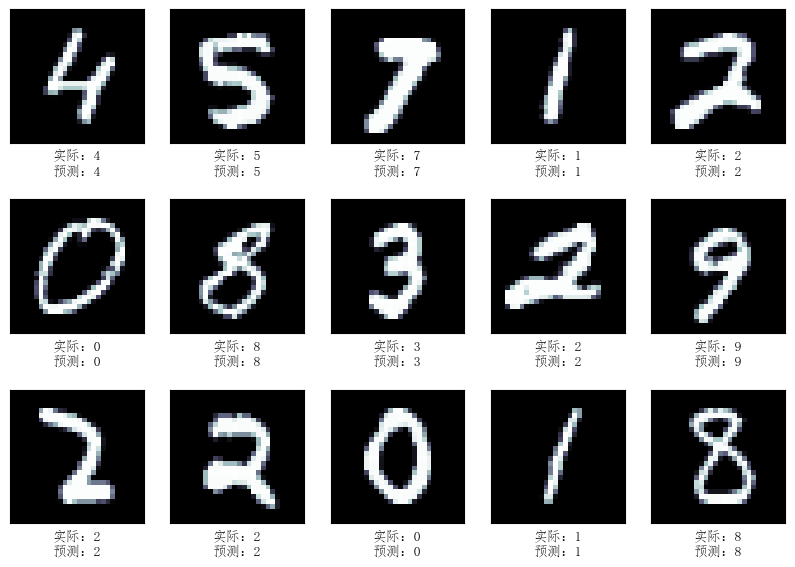

In [24]:
fig, ax = plt.subplots(3, 5, figsize=(10, 7))  # 创建一个2行4列的画布
for i, axi in enumerate(ax.flat):
    t = int(torch.randint(low=0, high=10000, size=(1, 1))[0][0])  # 生成随机整数t作为测试集的下标，可随机选取测试集中的图片
    x, y = test_data[t][0], test_data[t][1]
    x = x.to(device)
    pred = model(x)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    axi.imshow(x.reshape(28, 28), cmap="bone")  # 绘制图像
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(f"实际：{actual}\n预测：{predicted}")
plt.rcParams["font.sans-serif"] = "FangSong"
plt.show()